In [1]:
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test_dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

print(dataset)
print(test_dataset)

"""

    '0': Mild Dimentia
    '1': Moderate Dimentia
    '2': No Dimentia
    '3': Very Mild Dimentia

"""
classification_guide = {0:"Mild Dimentia", 1:"Moderate Dimentia", 2:"No Dimentia", 3:"Very Mild Dimentia"}

# dataset = dataset.with_format("torch")

# # Convert the Hugging Face dataset to a PyTorch DataLoader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32)

Using custom data configuration Falah--Alzheimer_MRI-e7a86d1feb6dc6a6
Found cached dataset parquet (/Users/ryanbrady/.cache/huggingface/datasets/Falah___parquet/Falah--Alzheimer_MRI-e7a86d1feb6dc6a6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Using custom data configuration Falah--Alzheimer_MRI-e7a86d1feb6dc6a6
Found cached dataset parquet (/Users/ryanbrady/.cache/huggingface/datasets/Falah___parquet/Falah--Alzheimer_MRI-e7a86d1feb6dc6a6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image', 'label'],
    num_rows: 5120
})
Dataset({
    features: ['image', 'label'],
    num_rows: 1280
})


In [2]:
labels = [x["label"] for x in dataset]
images = [x["image"] for x in dataset]
test_labels = [x["label"] for x in test_dataset]
test_images = [x["image"] for x in test_dataset]

transform = transforms.Compose([
    transforms.ToTensor()
])

# Convert images to tensor
image_tensors = torch.stack([transform(image) for image in images])
label_tensors = torch.tensor(labels)
test_image_tensors = torch.stack([transform(image) for image in test_images])
test_label_tensors = torch.tensor(test_labels)

In [3]:
image_tensors[0].shape

torch.Size([1, 128, 128])

No Dimentia


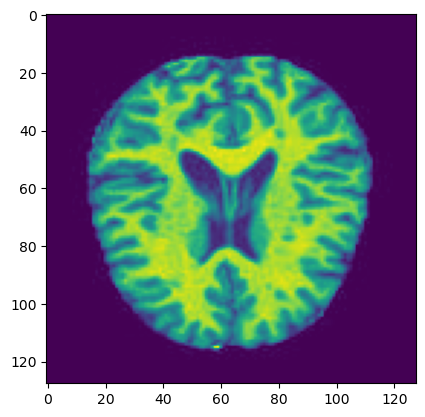

Mild Dimentia


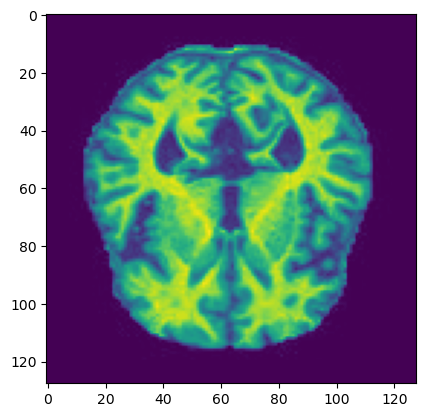

In [4]:
def load_image_into_plt(index):
    # Let's assume the images are in the range [-1, 1]. We'll need to add 1 to shift the range to [0, 2] and then divide by 2 to get [0, 1].
    unnormalize = transforms.Normalize((-1, ), (2, ))

    # Unnormalize the image
    img_unnorm = unnormalize(image_tensors[index])

    # Transpose the tensor to (Height, Width, Channels) because that's what matplotlib expects
    # Images are set currently to 1(channel), 128(height), 128(width)
    img_unnorm = img_unnorm.permute(1, 2, 0)

    # Show the image
    return classification_guide[labels[index]], img_unnorm

_class, image1 = load_image_into_plt(0) 
print(_class)
plt.imshow(image1)
plt.show()

_class2, image2 = load_image_into_plt(1) 
print(_class2)
plt.imshow(image2)
plt.show()


In [5]:
from torch.utils.data import DataLoader, TensorDataset

# Create a TensorDataset
dataset = TensorDataset(image_tensors, label_tensors)
test_dataset = TensorDataset(test_image_tensors, test_label_tensors)

# Create a DataLoader
batch_size = 32  # You can adjust the batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [6]:
image_tensors[0].shape

torch.Size([1, 128, 128])

In [7]:
# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(2, 2)  # kernel size, stride
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*29*29, 120) #image is now 16 by 29x29 pixels
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)  

    def forward(self, x):
        """
         1. Our input image is (1(channel), 128 (height in pixels), 128 (width in pixels))
           Our 5x5 Kernal adds padding so it eats up two pixels either side so 128 = 124
         2. After the image is passed through both conv's and pooling we have an image with
            (16 by 29x29)
            16 channels (or filters/features from our conv) by 29x29 pixels. Multiply and it equals 13456
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = x.view(-1, 16*29*29) # reshape with one row per image and one column per feature.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
outputs = net(image_tensors[0])
print("Predictions: ", outputs)
print(classification_guide[torch.argmax(outputs).item()])


Predictions:  tensor([[-0.0012,  0.1010, -0.0694, -0.0596]], grad_fn=<AddmmBackward0>)
Moderate Dimentia


In [8]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Now we'll train the network
for epoch in range(50):  # loop over the dataset multiple times

    net.train()  # Set the network to training mode
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] train loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # After each epoch, run a pass on the validation set
    net.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

        print('[%d] validation loss: %.3f, accuracy: %.2f' %
              (epoch + 1, val_loss / len(test_dataloader), correct / total * 100))

print('Finished Training')


[1] validation loss: 1.027, accuracy: 49.53
[2] validation loss: 1.027, accuracy: 49.53
[3] validation loss: 1.015, accuracy: 49.53
[4] validation loss: 0.999, accuracy: 50.70
[5] validation loss: 0.972, accuracy: 50.62
[6] validation loss: 0.984, accuracy: 50.62
[7] validation loss: 0.956, accuracy: 54.45
[8] validation loss: 0.929, accuracy: 53.83
[9] validation loss: 0.947, accuracy: 55.08
[10] validation loss: 0.934, accuracy: 53.59
[11] validation loss: 0.907, accuracy: 53.20
[12] validation loss: 0.899, accuracy: 56.95
[13] validation loss: 0.879, accuracy: 57.73
[14] validation loss: 0.883, accuracy: 57.66
[15] validation loss: 0.862, accuracy: 57.66
[16] validation loss: 0.857, accuracy: 60.00
[17] validation loss: 0.833, accuracy: 61.25
[18] validation loss: 0.839, accuracy: 61.09
[19] validation loss: 0.794, accuracy: 64.61
[20] validation loss: 0.797, accuracy: 63.83
[21] validation loss: 0.866, accuracy: 62.11
[22] validation loss: 0.689, accuracy: 69.06
[23] validation los

In [9]:
testloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

validation_images= []
validation_predictions = []
actual_predictions = []

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        validation_images.append(inputs)
        actual_predictions.append(labels)
        validation_predictions.append(outputs)

In [10]:
list_of_classifications =[]
for x in range(len(validation_predictions)):    
    argmax = torch.argmax(validation_predictions[x][0]).item()
    _class = classification_guide[argmax]
    list_of_classifications.append(_class)

Models Prediction: No Dimentia
Actual Prediction: No Dimentia


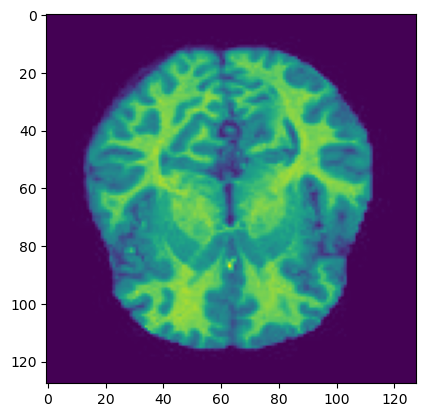

Models Prediction: Very Mild Dimentia
Actual Prediction: Very Mild Dimentia


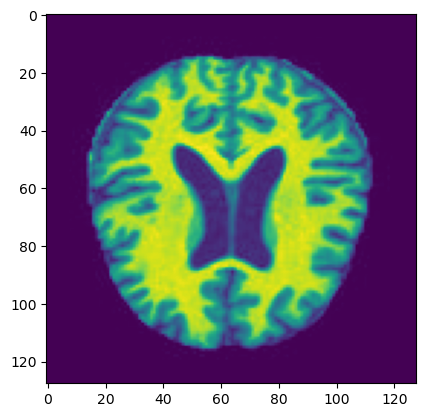

Models Prediction: Mild Dimentia
Actual Prediction: Mild Dimentia


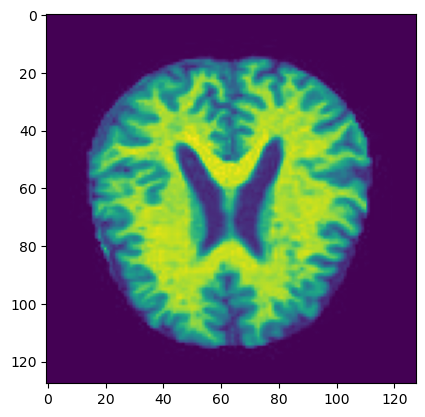

In [13]:
def load_predictions_into_plt(index):
    # Let's assume the images are in the range [-1, 1]. We'll need to add 1 to shift the range to [0, 2] and then divide by 2 to get [0, 1].
    unnormalize = transforms.Normalize((-1, ), (2, ))

    # Unnormalize the image
    img_unnorm = unnormalize(validation_images[index][0])

    # Transpose the tensor to (Height, Width, Channels) because that's what matplotlib expects
    # Images are set currently to 1(channel), 128(height), 128(width)
    img_unnorm = img_unnorm.permute(1, 2, 0)
    argmax = torch.argmax(validation_predictions[index]).item()
    # Show the image
    return classification_guide[actual_predictions[index].item()], classification_guide[argmax], img_unnorm

actual_pred, pred, image_pred = load_predictions_into_plt(1)
print(f"Models Prediction: {pred}")
print(f"Actual Prediction: {actual_pred}")
plt.imshow(image_pred,)
plt.show()

actual_pred, pred, image_pred = load_predictions_into_plt(12)
print(f"Models Prediction: {pred}")
print(f"Actual Prediction: {actual_pred}")
plt.imshow(image_pred,)
plt.show()

actual_pred, pred, image_pred = load_predictions_into_plt(25)
print(f"Models Prediction: {pred}")
print(f"Actual Prediction: {actual_pred}")
plt.imshow(image_pred,)
plt.show()